## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [3]:
df = pd.read_csv("data/train.csv",index_col=0)
df = df.dropna(axis=0)


y = df['is_duplicate']
X = df.drop('is_duplicate',axis=1)

y.index = X.index

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.75,random_state=1923)


### Exploration

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

X_train['question1'].map(lambda x: len(x.split(" "))).describe()

count    303215.000000
mean         10.938948
std           5.434235
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         125.000000
Name: question1, dtype: float64

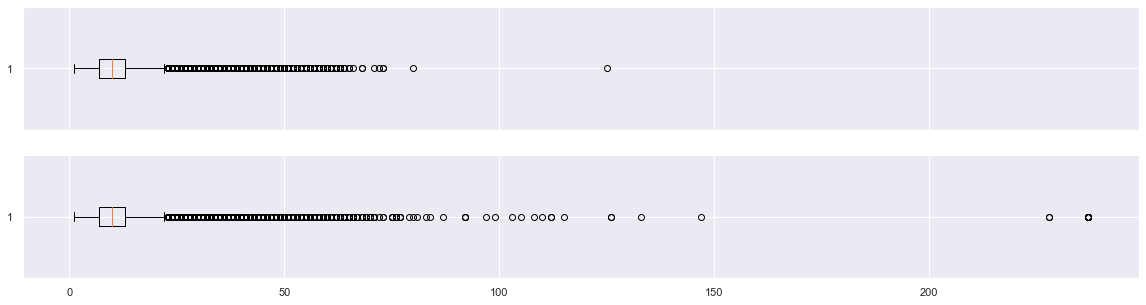

In [5]:
_, (ax1,ax2) = plt.subplots(2,1,sharex='all',figsize=(20,5))
ax1.boxplot(X_train['question1'].map(lambda x: len(x.split())), vert=False,);
ax2.boxplot(X_train['question2'].map(lambda x: len(x.split())),vert=False);



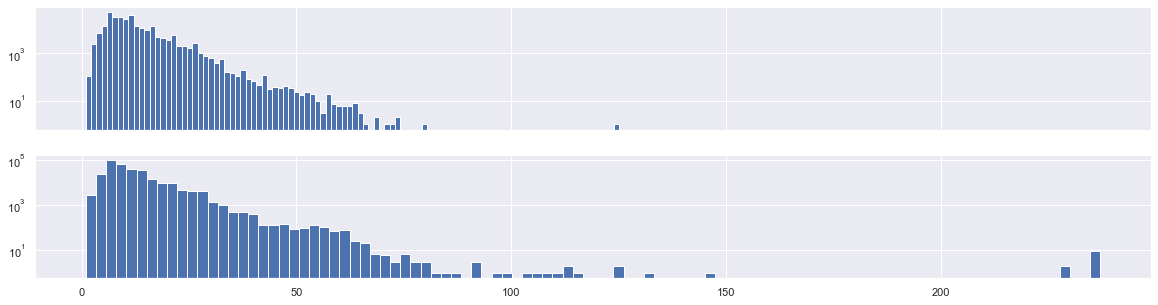

In [6]:
_, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(20,5));
ax1.hist(X_train['question1'].map(lambda x: len(x.split())),bins=100, log=True);
ax2.hist(X_train['question2'].map(lambda x: len(x.split())),bins=100, log=True);

In [7]:
ugh = df['qid1'].to_numpy()
lenlen = len(set(ugh.tolist() + df['qid2'].to_numpy().tolist()))

In [8]:
df.describe()


,qid1,qid2,is_duplicate
count,404287.000000,404287.000000,404287.000000
mean,217243.151093,220955.212082,0.369201
std,157751.614317,159903.168488,0.482589
min,1.000000,2.000000,0.000000
25%,74436.500000,74726.500000,0.000000
50%,192181.000000,197053.000000,0.000000
75%,346573.000000,354692.000000,1.000000
max,537932.000000,537933.000000,1.000000


In [9]:
print(len(set(df['qid1'])))

print(len(set(df['qid2'])))



290652
299362


In [10]:
print(len(df['qid1']))

404287


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [11]:
import nltk
from nltk.stem import WordNetLemmatizer

In [12]:
# Word Tokenization
from nltk.tokenize import NLTKWordTokenizer

tokenizer = NLTKWordTokenizer()
X_train['question1_tokens'] = X_train['question1'].map(tokenizer.tokenize)
X_train['question2_tokens'] = X_train['question2'].map(tokenizer.tokenize)

In [13]:
# Remove Stopwords
from nltk.corpus import stopwords
X_train2 = X_train

sw = stopwords.words('english')
X_train2['question1_tokens'] = X_train['question1_tokens'].map(lambda xs : [x for x in xs if not x.lower() in sw])
X_train2['question2_tokens'] = X_train['question2_tokens'].map(lambda xs : [x for x in xs if not x.lower() in sw])


In [14]:
# remove punctuation
from string import punctuation as punc_list
X_train2['question1_tokens'] = X_train2['question1_tokens'].map(lambda xs : [x for x in xs if not x in punc_list])
X_train2['question2_tokens'] = X_train2['question2_tokens'].map(lambda xs : [x for x in xs if not x in punc_list])

In [15]:
# Use porter's algorithm to get stems, and convert to lowercase!
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

X_train2['question1_tokens'] = X_train2['question1_tokens'].map(lambda xs : [stemmer.stem(x, to_lowercase=True) for x in xs])
X_train2['question2_tokens'] = X_train2['question2_tokens'].map(lambda xs : [stemmer.stem(x,to_lowercase=True) for x in xs])

In [16]:
X_train = X_train2[['qid1','question1_tokens','qid2','question2_tokens']]
X_train

,qid1,question1_tokens,qid2,question2_tokens
id,,,,
20369,38434,"[3, main, compon, cpu]",38435,"[main, compon, cpu]"
128211,206240,"[posit, neg, implic, could, come, time, travel]",206241,"[dark, upper, lip, turn]"
207728,311500,"[feel, see, time, 9:11, everytim, look, clock]",311501,"[mean, alway, see, 20:20, clock]"
327614,14244,"[one, correct, lunch, lunch, ate, lunch]",34902,"[determin, use, etc]"
206680,310177,"[read, quora]",120989,"[peopl, use, quora]"
...,...,...,...,...
363276,227992,"[place, india, everi, indian, visit, least, life]",385352,"[place, everyon, visit, india, life]"
308849,26089,"[live, happi, life]",260208,"[person, live, success, happi, life, invest]"
151699,238470,"[factori, reset, ipod, touch]",238471,"[perform, factori, reset, ipod, touch]"


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
class QuoraCleaner(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        pass

    def transform(self,X,y=None):
        # tokenize strings
        from nltk.tokenize import NLTKWordTokenizer
        tokenizer = NLTKWordTokenizer()
        X['question1_tokens'] = X['question1'].map(tokenizer.tokenize)
        X['question2_tokens'] = X['question2'].map(tokenizer.tokenize)

        # remove stopwords
        from nltk.corpus import stopwords
        sw = stopwords.words('english')
        X['question1_tokens'] = X['question1_tokens'].map(lambda xs : [x for x in xs if not x.lower() in sw])
        X['question2_tokens'] = X['question2_tokens'].map(lambda xs : [x for x in xs if not x.lower() in sw])

        # remove punctuation
        from string import punctuation as punc_list
        X['question1_tokens'] = X['question1_tokens'].map(lambda xs : [x for x in xs if not x in punc_list])
        X['question2_tokens'] = X['question2_tokens'].map(lambda xs : [x for x in xs if not x in punc_list])

        # Use porter's algorithm to get stems.
        from nltk.stem import PorterStemmer
        stemmer = PorterStemmer()
        X['question1_tokens'] = X['question1_tokens'].map(lambda xs : [stemmer.stem(x, to_lowercase=True) for x in xs])
        X['question2_tokens'] = X['question2_tokens'].map(lambda xs : [stemmer.stem(x,to_lowercase=True) for x in xs])

        X = X[['qid1','question1_tokens','qid2','question2_tokens']]

        return X


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [18]:
# get uniq list of all documents for vectorization
import numpy as np

temp1 = X_train[['qid1','question1_tokens']].groupby('qid1').first()
temp1 = temp1.reset_index()

temp1.columns = ['qid','tokens']

temp2 = X_train[['qid2','question2_tokens']].groupby('qid2').first()
temp2 = temp2.reset_index()
temp2.columns = ['qid','tokens']
uniqs = pd.concat([temp1,temp2],axis=0).groupby('qid').first()

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vec_count = CountVectorizer(preprocessor=' '.join)


In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
tran_tfidf = TfidfTransformer()

# tfidf_pipe = Pipeline([('count',vec_count),('tfidf',tran_tfidf)]).fit(uniqs['tokens'])



In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec_tfidf = TfidfVectorizer(preprocessor=' '.join,ngram_range=(1,3)).fit(uniqs['tokens'])


In [22]:
q1_tfidf = vec_tfidf.transform(X_train['question1_tokens'])
q2_tfidf = vec_tfidf.transform(X_train['question2_tokens'])

In [23]:
from sklearn.metrics.pairwise import paired_cosine_distances
X_train['tfidf_cos_distances'] = paired_cosine_distances(q1_tfidf,q2_tfidf)

C:\Users\thowe\AppData\Local\Temp\ipykernel_13828\1996137371.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['tfidf_cos_distances'] = paired_cosine_distances(q1_tfidf,q2_tfidf)


In [44]:
import gensim
from gensim.models import Word2Vec
from gensim.similarities import WordEmbeddingSimilarityIndex, SparseTermSimilarityMatrix, SoftCosineSimilarity
import gensim.models.keyedvectors as word2vec
w2v = word2vec.load_word2vec_format('C:/Users/thowe/.word2vec/GoogleNews-vectors-negative300.bin',binary=True,)

In [26]:
q1_num_words = X_train['question1_tokens'].apply(len)
q2_num_words = X_train['question2_tokens'].apply(len)
X_train['difference_in_number_of_words'] = q1_num_words - q2_num_words

def cosine_sim(vecA, vecB):
    """
    Find the cosine similarity distance between two vectors.

    :param vecA: the first vector for the similarity calculation
    :param vecB: the second vector for the similarity calculation
    :return: The cosine similarity of the two vectors
    """
    cos_sim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
    if np.isnan(np.sum(cos_sim)):
        return 0
    return cos_sim

In [58]:

# keys = w2v.index_to_key
vocab = np.concatenate(list(uniqs['tokens']))
vocab = list(set(vocab))
len(vocab)
w2v_stems = pd.DataFrame(w2v.index_to_key).applymap(stemmer.stem)


,0
0,</s>
1,in
2,for
3,that
4,is
...,...
2999995,raffael
2999996,bim_skala_bim
2999997,mezze_caf
2999998,pulverizes_bould


In [78]:
len(vocab)

84280

In [84]:
uniqs

,tokens
qid,
3,"[stori, kohinoor, koh-i-noor, diamond]"
4,"[would, happen, indian, govern, stole, kohinoo..."
5,"[increas, speed, internet, connect, use, vpn]"
6,"[internet, speed, increas, hack, dn]"
7,"[mental, lone, solv]"
...,...
537925,"[cpu, upgrad, 2016, appl, macbook, pro, mean]"
537926,"[jainism, say, homosexu]"
537927,"[jainism, say, gay, homosexu]"


In [32]:
embed_dict = {}

stem_dict = []
for index, word in enumerate(vocab):
    try:
        idx_dict[index] = w2v[word]
    except:
        pass
del w2v

In [33]:
keys=embed_dict.keys()

In [145]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# documents = [TaggedDocument(doc, tags=[i]) for i, doc in uniqs.iterrows()]
documents2 = [TaggedDocument(*doc, tags=[i]) for i, doc in uniqs.iterrows()]


In [114]:
model = Doc2Vec(documents2, vector_size=50, window=5, min_count=1, workers=7,epochs=1,negative=0,hs=1)


In [148]:
model.train(total_words=len(vocab),total_examples=len(uniqs),corpus_iterable=documents2,epochs=5,report_delay=1)

TypeError: Word2Vec._train_epoch() got an unexpected keyword argument 'negative'

In [155]:
model.dv.index_to_key

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [150]:
X_train

,qid1,question1_tokens,qid2,question2_tokens,tfidf_cos_distances,difference_in_number_of_words,mean_w2v_cos_similarity,difference_in_word_vec_sum
id,,,,,,,,
20369,38434,"[3, main, compon, cpu]",38435,"[main, compon, cpu]",0.000000,1,0,0.0
128211,206240,"[posit, neg, implic, could, come, time, travel]",206241,"[dark, upper, lip, turn]",1.000000,3,0,0.0
207728,311500,"[feel, see, time, 9:11, everytim, look, clock]",311501,"[mean, alway, see, 20:20, clock]",0.942349,2,0,0.0
327614,14244,"[one, correct, lunch, lunch, ate, lunch]",34902,"[determin, use, etc]",1.000000,3,0,0.0
206680,310177,"[read, quora]",120989,"[peopl, use, quora]",0.885291,-1,0,0.0
...,...,...,...,...,...,...,...,...
363276,227992,"[place, india, everi, indian, visit, least, life]",385352,"[place, everyon, visit, india, life]",0.919887,2,0,0.0
308849,26089,"[live, happi, life]",260208,"[person, live, success, happi, life, invest]",0.760763,-3,0,0.0
151699,238470,"[factori, reset, ipod, touch]",238471,"[perform, factori, reset, ipod, touch]",0.151386,-1,0,0.0


In [159]:

q1_word_vec_mean = X_train['question1_tokens'].apply(lambda xs: np.mean([model.wv[x] for x in xs ],axis=0))
q2_word_vec_mean = X_train['question2_tokens'].apply(lambda xs: np.mean([model.wv[x] for x in xs ],axis=0))
# q1_word_vec_mean = X_train['question1_tokens'].apply(lambda xs: np.mean([model.wv[x] for x in xs if x in keys],axis=0))
# q2_word_vec_mean = X_train['question2_tokens'].apply(lambda xs: np.mean([model.wv[x] for x in xs if x in keys],axis=0))
X_train['mean_w2v_cos_similarity'] = [cosine_sim(a,b) for a, b in zip(q1_word_vec_mean,q2_word_vec_mean)]


C:\Users\thowe\miniconda3\envs\LighthouseEnv\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [161]:
# q1_word_vec_sum = X_train['question1_tokens'].apply(lambda xs: np.sum([embed_dict[x] for x in xs if x in keys],axis=0))
# q2_word_vec_sum = X_train['question2_tokens'].apply(lambda xs: np.sum([embed_dict[x] for x in xs if x in keys],axis=0))

q1_word_vec_sum = X_train['question1_tokens'].apply(lambda xs: np.sum([model.wv[x] for x in xs],axis=0))
q2_word_vec_sum = X_train['question2_tokens'].apply(lambda xs: np.sum([model.wv[x] for x in xs],axis=0))
X_train['difference_in_word_vec_sum'] = q1_word_vec_sum - q2_word_vec_sum

In [144]:
X_train

TypeError: 'dict' object is not callable

In [135]:
X_train['question1_tokens']

id
20369                                [3, main, compon, cpu]
128211      [posit, neg, implic, could, come, time, travel]
207728       [feel, see, time, 9:11, everytim, look, clock]
327614             [one, correct, lunch, lunch, ate, lunch]
206680                                        [read, quora]
                                ...                        
363276    [place, india, everi, indian, visit, least, life]
308849                                  [live, happi, life]
151699                        [factori, reset, ipod, touch]
328037                       [canon, lens, get, 750d, 760d]
254671             [common, trait, highli, intellig, peopl]
Name: question1_tokens, Length: 303215, dtype: object

In [ ]:
X_train.difference_in_word_vec_sum.describe()

In [ ]:
X_train_f = X_train.drop(['qid1','qid2','question1_tokens','question2_tokens'],axis=1)

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=1738,subsample=0.7,colsample_bytree=0.8)

In [ ]:
clf.fit(X_train_f,y_train)